In [1]:
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.pipeline import make_pipeline

from scipy.stats import chi2_contingency
from pipelines import pipe, pipe2, extra_features
#from preprocess import extra_features, separate

In [2]:
train=pd.read_csv("../Datasets/train.csv")
train.set_index("Tour_ID", inplace=True)
train.tail(3)

<IPython.core.display.Javascript object>

,country,age_group,travel_with,total_female,total_male,purpose,main_activity,info_source,tour_arrangement,package_transport_int,package_accomodation,package_food,package_transport_tz,package_sightseeing,package_guided_tour,package_insurance,night_mainland,night_zanzibar,first_trip_tz,cost_category
Tour_ID,,,,,,,,,,,,,,,,,,,,
tour_idv7pz3vs8,UNITED STATES OF AMERICA,25-44,With Spouse and Children,2.0,1.0,Leisure and Holidays,Widlife Tourism,"Travel agent, tour operator",Independent,No,No,No,No,No,No,No,9,0,Yes,Higher Cost
tour_idy6ydo00w,UNITED STATES OF AMERICA,25-44,With Spouse,1.0,1.0,Leisure and Holidays,Conference Tourism,"Radio, TV, Web",Package Tour,Yes,Yes,Yes,Yes,Yes,Yes,No,13,4,No,Higher Cost
tour_idceoq9por,OMAN,25-44,With Spouse and Children,2.0,1.0,Visiting Friends and Relatives,Wildlife Tourism,"Friends, relatives",Independent,No,No,No,No,No,No,No,22,0,No,Low Cost


In [3]:
X=train.drop(['cost_category'], axis=1)
y=train['cost_category']

In [4]:
col_drop=[]

for col in X.columns:
    
    ct=pd.crosstab(y, X[col])
    chi2, P, dof , _ = chi2_contingency(ct)
    
    if P >= 0.05 or chi2 <= 1000 :
        col_drop.append(col)
        
    #print(f"Column: {col}\nChi_Test: {chi2}\nP_Value: {P}\nDegree: {dof}\n*************")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
col_drop

[]

In [6]:
le=LabelEncoder()
y=le.fit_transform(y)

In [7]:
#from preprocess import separate
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, OrdinalEncoder, RobustScaler, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction import DictVectorizer, FeatureHasher
import pandas as pd
import itertools

In [59]:
cat = []
huge_cat = []
num = [c for c in train.select_dtypes('int','float').columns]
for col in train.select_dtypes(['object', 'category']).columns:
    if col not in ['cost_category']:
        num_values=len(train[col].unique())
        if num_values<=20:
            cat.append(col)
        else:
            huge_cat.append(col)

num_pipeline=Pipeline([
    ("imputer", SimpleImputer(strategy='median')),
    ("scaler", StandardScaler()),
])

cat_pipeline=Pipeline([
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("hash", FeatureHasher(input_type='string'), "document"),
    ("encoder", OneHotEncoder(sparse_output=False)),
])

lcat_pipeline=Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("enc", OrdinalEncoder()),
])

pipe=ColumnTransformer([ 
    ("cat", cat_pipeline, cat),
    ("num", num_pipeline, num),
    ("text", lcat_pipeline, huge_cat),

])

In [8]:
X = pipe2(X)
#X_test = pipe.transform(X_test)

In [9]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size=0.3, stratify=y, random_state=123)

In [10]:
y_train

array([5, 3, 0, ..., 3, 5, 1])

In [11]:
lgb=LGBMClassifier()

lgb.fit(X_train, y_train)#, callbacks=log_evaluation())

LGBMClassifier()

In [12]:
y_pred= lgb.predict(X_test)

In [13]:
print(classification_report(y_pred, y_test, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.33      0.49      0.40       758
 Higher Cost       0.77      0.64      0.70      1753
Highest Cost       0.08      0.23      0.12        40
    Low Cost       0.07      0.36      0.11        86
  Lower Cost       0.66      0.58      0.62       877
 Normal Cost       0.68      0.55      0.61      2038

    accuracy                           0.57      5552
   macro avg       0.43      0.47      0.43      5552
weighted avg       0.65      0.57      0.60      5552



In [14]:
preds = lgb.predict_proba(X_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, preds, multi_class='ovr'))

0.8432811144791837


In [15]:
kfolds= StratifiedKFold(n_splits=10, shuffle=True, random_state=123)


for fold, (train_idx, val_idx) in enumerate(kfolds.split(X,y)):
    X_train, X_test=X[train_idx], X[val_idx]
    y_train, y_test=y[train_idx], y[val_idx]

lgb.fit(X_train, y_train)    

LGBMClassifier()

In [16]:
y_pred=lgb.predict(X_test)

In [17]:
print(classification_report(y_pred, y_test, target_names=le.classes_))

              precision    recall  f1-score   support

   High Cost       0.37      0.49      0.42       278
 Higher Cost       0.77      0.63      0.69       595
Highest Cost       0.11      0.29      0.16        14
    Low Cost       0.03      0.15      0.04        26
  Lower Cost       0.59      0.58      0.58       263
 Normal Cost       0.66      0.53      0.59       674

    accuracy                           0.56      1850
   macro avg       0.42      0.45      0.42      1850
weighted avg       0.63      0.56      0.59      1850



In [18]:
print(f1_score(y_test, y_pred, average="micro"))

0.5572972972972973


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

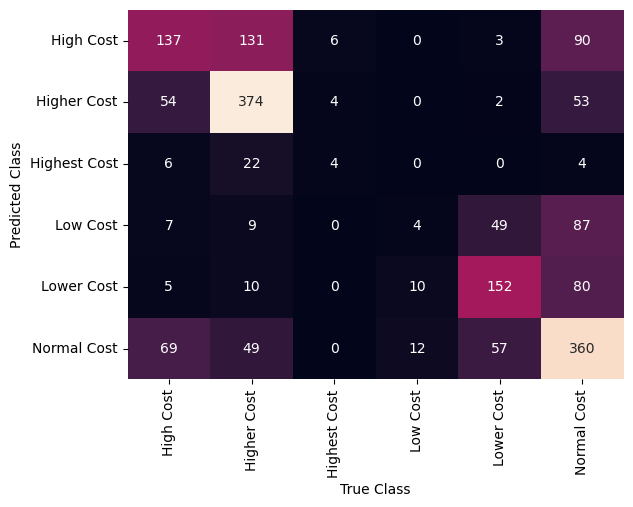

In [19]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cbar=False,
           xticklabels=le.classes_,
           yticklabels=le.classes_)

plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.show();

In [20]:
lgb.score(X_test, y_test)

0.5572972972972973

In [21]:
X.shape

(18506, 147)

In [24]:
import os 
import pickle

dire = os.path.dirname('.')

pickle.dump(lgb,
            open(os.path.join(dire, 'FlaskApp', 'pickle_objects', 'LGBM.pkl'), 'wb'), protocol=4)

In [40]:
test = pd.read_csv('../Datasets/test.csv')
test.drop('Tour_ID',axis=1, inplace=True)

In [42]:
x = test[:1]
x = pipe2(x)
x.shape[1]

17

In [44]:
pd.Series(x)

ValueError: Data must be 1-dimensional

In [38]:
X.shape[1]

147